In this project, you will filter observations in a dataset based on the geographic location: select the firms that are within 50 miles of the state boundary between Oregon and Washington.

1. Download data
    1. Download the excel data file from Canvas: NETS_Sample2022.xlsx. This file inlcudes sample data for firm establishments in the US. Find the two columns ("Latitude" and "Longitude") that contain the geographic location of the firm establishments.
    2. Go to US Census website https://www.census.gov/cgi-bin/geo/shapefiles/index.php and download the shapefiles for the 2020 States (and equivalent). This gives the state boundaries.

In [17]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Load the state boundaries shapefile
shapefile_path = "/Users/mcgla/Desktop/AEC627/Project1/tl_2020_us_state.zip"  # Update the path
states = gpd.read_file(shapefile_path)

# Load the firm establishment data from the Excel file
file_path = "NETS_Sample2022.xlsx"  # Update the path
firm_data = pd.read_excel(file_path)

firm_data["Longitude"] = firm_data["Longitude"].apply(lambda x: -x if x > 0 else x)

c:\Users\mcgla\anaconda3\envs\myenv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


2. Create GeoDataFrames.
    1. Use geopandas to read the shapefile for the state boundaries. Keep only the 48 conterminous states. 
    2. Create a GeoDataFrame using the latitude and longitude information in the firm establishment data. Use crs='epsg:4326' as the Geographic Coordinate System.
    3. Convert the coordinate system of both GeoDataFrames into Albers Equal Area Projection System, so that you can calculate distance to the state boundary.   

In [18]:
#1
# Keep only the 48 conterminous states
excluded_states_shp = ["02", "15", "60", "66", "69", "72", "78"]  # Alaska, Hawaii, Territories
conterminous_states = states[~states["STATEFP"].isin(excluded_states_shp)]

excluded_states = ["AK", "HI", "PR"]
firm_data = firm_data[~firm_data["State"].isin(excluded_states)]

#2
# Create a GeoDataFrame for the firm data
firm_geometry = [Point(xy) for xy in zip(firm_data["Longitude"], firm_data["Latitude"])]
firm_gdf = gpd.GeoDataFrame(firm_data, geometry=firm_geometry, crs="EPSG:4326")

#3
# Convert to Albers Equal Area projection
conterminous_states_albers = conterminous_states.to_crs("EPSG:5070")
firm_gdf_albers = firm_gdf.to_crs("EPSG:5070")

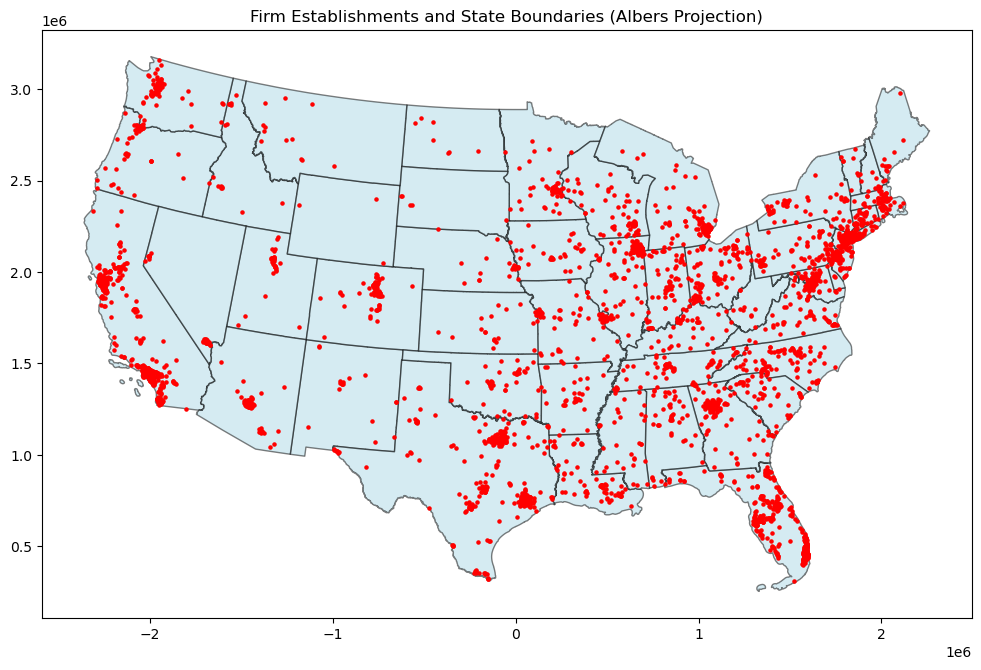

In [26]:
#Check to see if GeoDataFrames are aligned properly

# Plot the data
fig, ax = plt.subplots(figsize=(12, 12))
conterminous_states_albers.plot(ax=ax, edgecolor="black", color="lightblue", alpha=0.5)
firm_gdf_albers.plot(ax=ax, color="red", markersize=5)
plt.title("Firm Establishments and State Boundaries (Albers Projection)")
plt.show()


3. Select the firm establishments that are located within 50 miles from the common state boundary.
    1. Idenfity and common boundary between Oregon and Washington.
    2. Create a buffer area of 50 miles on both sides of the common boundary.
    3. Select firms that are within the buffer area.

In [19]:
#1
# Filter the GeoDataFrame for Oregon and Washington
oregon = conterminous_states_albers[conterminous_states_albers['STUSPS'] == 'OR']
washington = conterminous_states_albers[conterminous_states_albers['STUSPS'] == 'WA']

# Identify the common boundary (intersection of their geometries)
common_boundary = oregon.geometry.unary_union.intersection(washington.geometry.unary_union)

# Create a GeoDataFrame for the common boundary
import geopandas as gpd
from shapely.geometry import LineString

common_boundary_gdf = gpd.GeoDataFrame(geometry=[common_boundary], crs=conterminous_states_albers.crs)

#2
# Create a buffer area of 50 miles (50 * 1609.34 meters)
buffer_distance = 50 * 1609.34  # Convert miles to meters
buffer_area = common_boundary.buffer(buffer_distance)

# Create a GeoDataFrame for the buffer area
buffer_area_gdf = gpd.GeoDataFrame(geometry=[buffer_area], crs=conterminous_states_albers.crs)

#3
# Select firms that are within the buffer area
firms_within_buffer = firm_gdf_albers[firm_gdf_albers.geometry.within(buffer_area)]

<Axes: >

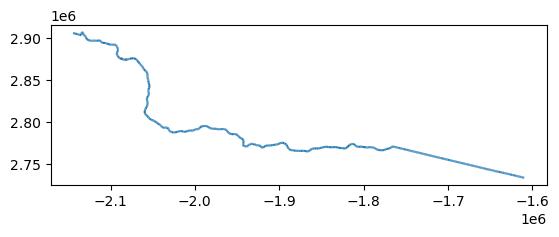

In [25]:
#Check common boundry
common_boundary_gdf.plot()

<Axes: >

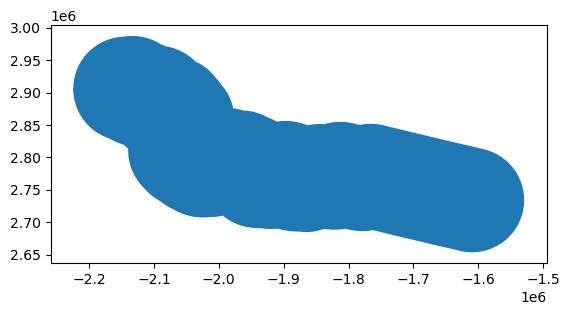

In [27]:
#Check buffer area  (50 miles)
buffer_area_gdf.plot()

<Axes: >

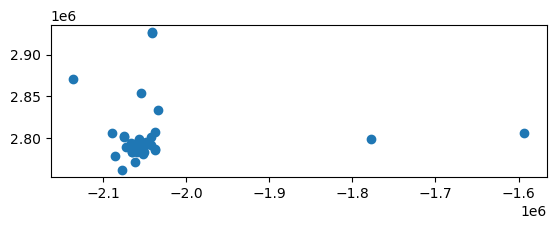

In [28]:
#Check firms within buffer area
firms_within_buffer.plot()

4. Generate a map.
    1. Plot the state boundaries in black. The common boundary between Oregon and washington is in red.
    2. plot the establishments in yellow. The establishments within 50 miles of common boundary are in green. 
    3. Zoom the map to scale that only covers Washington and Oregon.

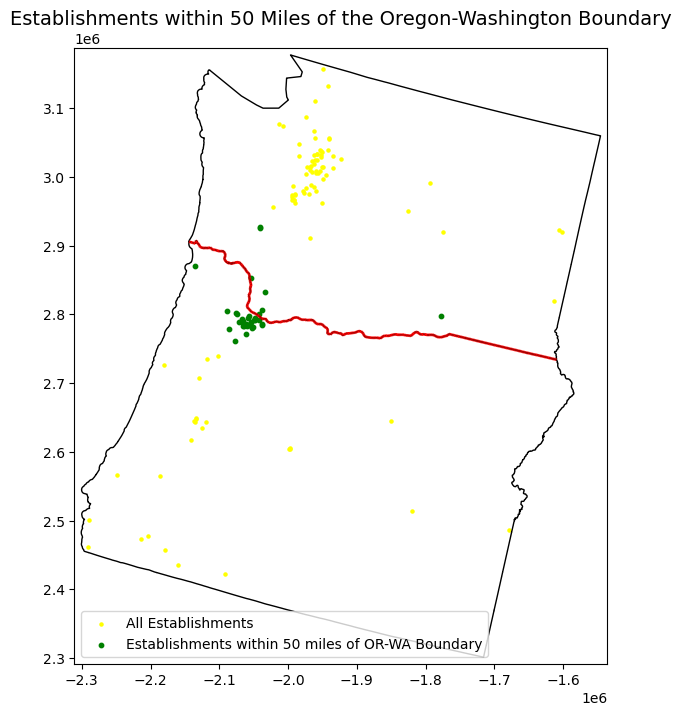

In [20]:
# Filter state boundaries for Oregon and Washington
or_wa_states = conterminous_states_albers[conterminous_states_albers['STUSPS'].isin(['OR', 'WA'])]

# Filter firms to include only those in Oregon or Washington
firms_or_wa = firm_gdf_albers[firm_gdf_albers['State'].isin(['OR', 'WA'])]

# Filter firms within the buffer to include only those in Oregon or Washington
firms_within_buffer_or_wa = firms_within_buffer[firms_within_buffer['State'].isin(['OR', 'WA'])]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot state boundaries in black
or_wa_states.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot the common boundary between Oregon and Washington in red
common_boundary_gdf = gpd.GeoDataFrame(geometry=[common_boundary], crs=conterminous_states_albers.crs)
common_boundary_gdf.plot(ax=ax, color='red', linewidth=2)

# Plot all establishments in Oregon or Washington in yellow
firms_or_wa.plot(ax=ax, color='yellow', markersize=5, label='All Establishments')

# Plot establishments within 50 miles of the common boundary in green
firms_within_buffer_or_wa.plot(ax=ax, color='green', markersize=10, label='Establishments within 50 miles of OR-WA Boundary')

# Set map extent to zoom into Oregon and Washington
minx, miny, maxx, maxy = or_wa_states.total_bounds
ax.set_xlim(minx - 10_000, maxx + 10_000)  # Add padding around the states
ax.set_ylim(miny - 10_000, maxy + 10_000)

# Add a legend
plt.legend(loc='lower left')

# Add a title
plt.title("Establishments within 50 Miles of the Oregon-Washington Boundary", fontsize=14)

# Display the map
plt.show()

Final map of firms within 50 miles of the Oregon-Washington border:

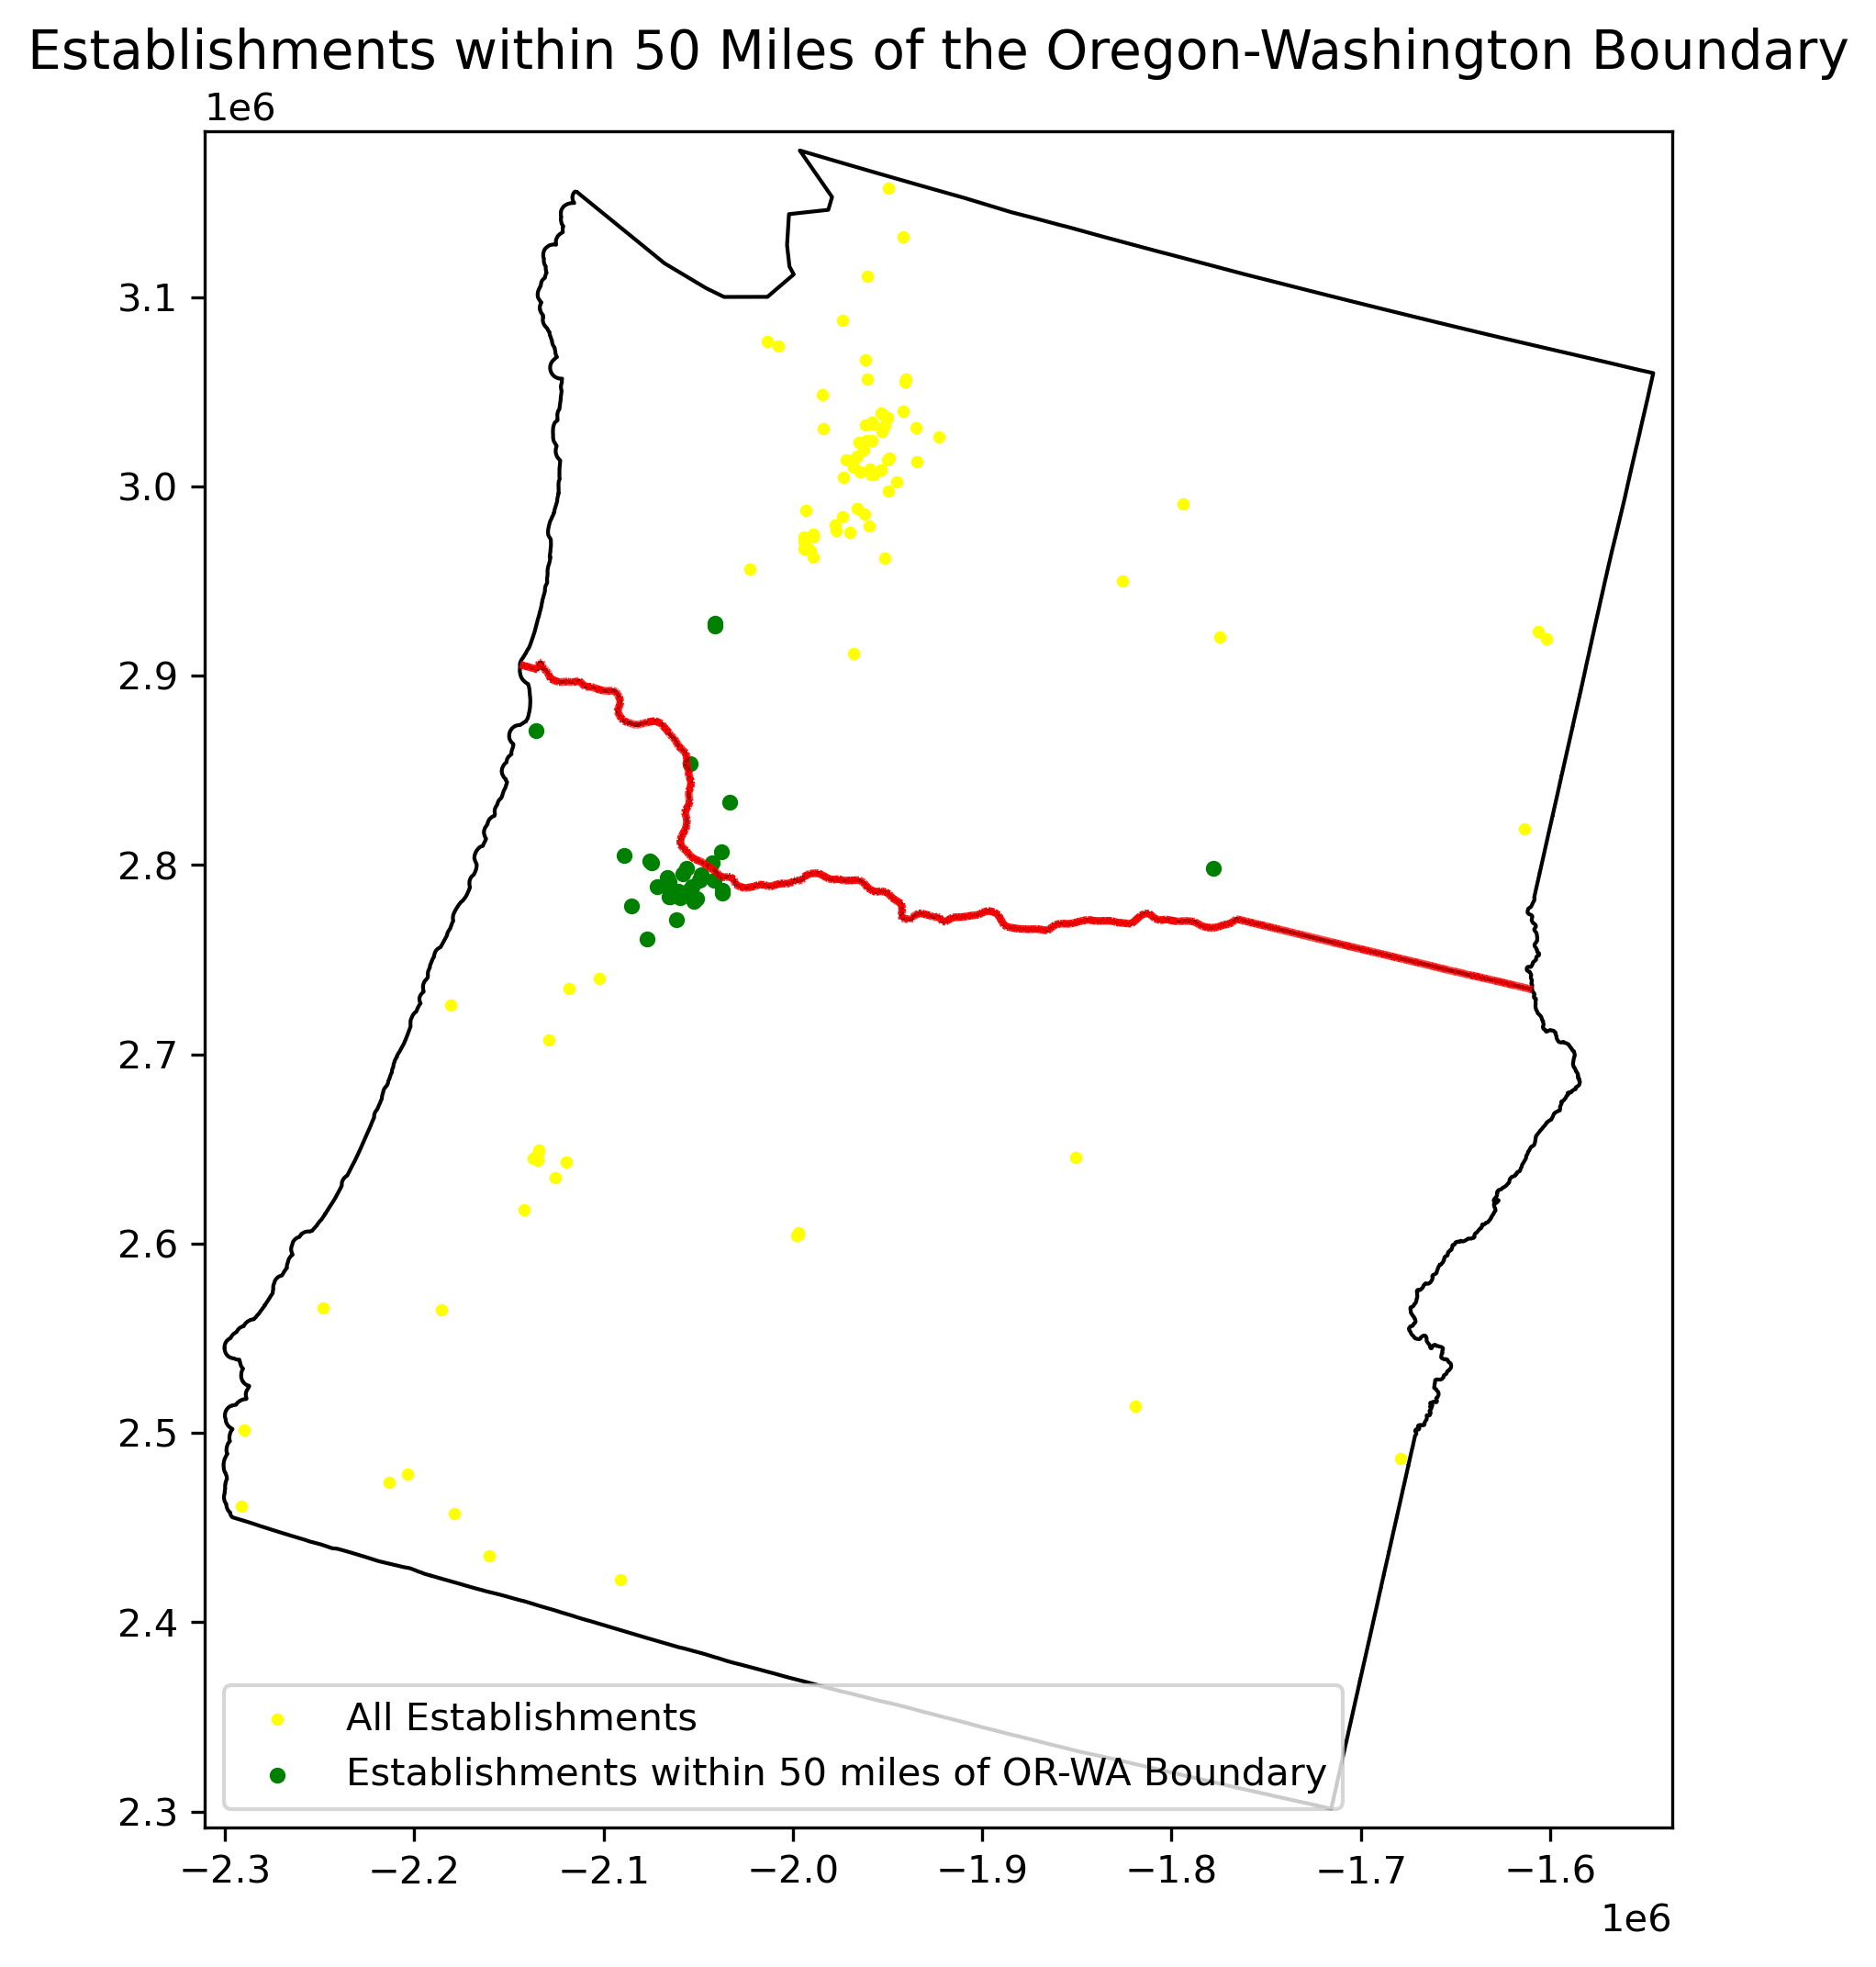